### Use Cases of Vector Data Base


* Long term Memory for LLM
* Semantic Search (similarity between words meaning with the context)
* Simiilarity Search (Similarity between unstruched unstructured data)
* Personalized Recommendation
* Clustering and Classifications
* Anomaly Detection

### Python and SQLite

In [1]:
import sqlite3

In [2]:
# create a connection to the SQLite DB
conn=sqlite3.connect('test.db')

In [3]:
# create a cursor object to execute SQL Commands
cursor = conn.cursor()

In [4]:
# create a table 
cursor.execute(
"""
CREATE TABLE IF NOT EXISTS test_employee(
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    age INTEGER,
    department TEXT
)
"""

)

In [5]:
# Intert data into table
cursor.execute(
"INSERT INTO test_employee(name,age,department) VALUES (? , ? , ?) " ,
    ('John Doe' , 30 , 'Sales')
    
)

In [6]:
# Retreive Data
cursor.execute("SELECT * FROM test_employee")

In [7]:
rows = cursor.fetchall()

In [8]:
rows

[(1, 'John Doe', 30, 'Sales'),
 (2, 'John Doe', 30, 'Sales'),
 (3, 'John Doe', 30, 'Sales')]

In [9]:
# Affter doing the changers we can commit the changes and close the connection
conn.commit()
conn.close()

### SQLite DB: Storing and Retrieving Vectors

In [10]:
# !pip install sqlite3
import sqlite3
import numpy as np


In [11]:
# Create the connection to the SQLite DB
conn = sqlite3.connect('vector-db.db')
# Create a cursor object to execute SQL Commands
cursor = conn.cursor()

In [12]:
# Create a table for vetor data
cursor.execute(
"""
CREATE TABLE IF NOT EXISTS vectors (
    id INTEGER PRIMARY KEY,
    vector BLOB NOT NULL
)
"""
)

In [13]:
# Generate some sample vectors
vect1 = np.array([1.2, 3.4, 2.1, 0.8])
vect2 = np.array([2.7, 1/5, 3.9, 2.3])

In [14]:
# Insert vector data into table 
cursor.execute (
"INSERT INTO vectors (vector) VALUES (?)",
    (sqlite3.Binary(vect1.tobytes()),))

In [15]:
# Insert vector data into table 
cursor.execute (
"INSERT INTO vectors (vector) VALUES (?)",
    (sqlite3.Binary(vect2.tobytes()),))

In [16]:
# Retreive data 
cursor.execute("SELECT vector FROM vectors")

In [17]:
rows = cursor.fetchall()
rows

[(b'333333\xf3?333333\x0b@\xcd\xcc\xcc\xcc\xcc\xcc\x00@\x9a\x99\x99\x99\x99\x99\xe9?',),
 (b'\x9a\x99\x99\x99\x99\x99\x05@\x9a\x99\x99\x99\x99\x99\xc9?333333\x0f@ffffff\x02@',)]

In [18]:
vector = np.frombuffer(rows[0][0] , dtype = np.float64)
vector

array([1.2, 3.4, 2.1, 0.8])

In [19]:
vector = np.frombuffer(rows[1][0] , dtype = np.float64)
vector

array([2.7, 0.2, 3.9, 2.3])

### Vector Similarity Search Using SQLite

In [20]:
query_vect = np.array([1.0,3.2,2.0,0.5])


In [21]:
cursor.execute("SELECT vector FROM vectors ORDER BY abs(vector - ?) ASC",
              (sqlite3.Binary(query_vect.tobytes()),))

In [22]:
res = cursor.fetchone()
res

(b'\x9a\x99\x99\x99\x99\x99\x05@\x9a\x99\x99\x99\x99\x99\xc9?333333\x0f@ffffff\x02@',)

In [23]:
np.frombuffer(res[0] , dtype = np.float64)

array([2.7, 0.2, 3.9, 2.3])

### Semantic Search Using Chorma DB

In [24]:
# !pip install chromadb
import chromadb
import pandas as pd

In [25]:
df = pd.read_csv("medium_post_titles.csv")
df.head()

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False
3,equality,"""Call me Nat Love"" :Black Cowboys and the Fron...",NaN,False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False


In [26]:
df = df.dropna()
df = df[~df["subtitle_truncated_flag"]]


topics_of_interest = ['artificial-intelligence' , 'data-science','machine-learning']
# topics_of_interest = ['data-science']

df = df[df['category'].isin(topics_of_interest)]
df['text'] = df['title']+df['subtitle']

df['meta'] = df.apply(lambda x: { #Use lambda functions when an anonymous function is required for a short period of time.
    'text' : x['text'],
    'category':x['category']
},axis=1)


In [27]:
df.to_csv('file2.csv')

### Chroma DB Setup

In [28]:
from chromadb.config import Settings

In [29]:
# In memory database(Inside the RAM)
## Chrome DB Setup
# chroma_client = chromadb.Client() 

##Collection creation
# article_collection = chroma_client.create_collection(name="medium-article-v")

# In Chroma DB Client
## Chroma DB Setup
# chroma_client = chromadb.Client(Settings(
#     persist_directory="medium-chroma-db",
#     chroma_db_impl="duckdb+parquet"
# ))  # persistent memory

chroma_client = chromadb.PersistentClient(path="medium-chroma-db")

##Collection creation
article_collection = chroma_client.create_collection(name="medium-article-v")

UniqueConstraintError: Collection medium-article-v already exists

### Data Insertion

In [ ]:
# Inserting Data 
article_collection.upsert(
    ids=[f"{x}" for x in df.index.tolist()], # get the index column and convert those integers in to strings
    documents=df['text'].tolist(),
    metadatas=df['meta'].tolist()   
)


##### Difference between upsert and add



$.add()$ - adding vectors in to collection 

$ .upsert() $ - Updaing and Inserting vectors in to collection

### Vector Query

In [ ]:
qry_str = "identify cat and dog?"

In [ ]:
article_collection.query(query_texts = qry_str , n_results=1)

In [ ]:
article_collection.delete()

## Working with PineCone 

In [ ]:
!pip install pinecone-client

In [27]:
import pinecone

In [28]:
# had a issue with finding the environment String so i just create a 
pinecone.init(api_key="6855c9be-79fa-4814-938f-e24d9140c7b0", environment="gcp-starter" )

In [ ]:
# Creating an Index in pinecone
# if you want to see the quick detail about the function then hold shift with tab
pinecone.create_index(name="insert" , dimension = 3 )

In [ ]:
# To view the index  
pinecone.list_indexes()

## Inserting Vectors to the data base

In [ ]:
# creating a vector 
vector = [[1,3,4],[5,6,7],[8,9,0]]

In [ ]:
vect_ids = ['vec1','vec2','vec3']

In [ ]:
idx = pinecone.Index('insert')

In [ ]:
idx.upsert([
    ('vec1',[1,3,4]),
    ('vec2',[5,6,7]),
    ('vec3',[8,9,0])
    
])#List of vectors

## Updating Vector to the data base

1. List of Vectors to be inserted first,


    ("A",[0.1,0.1,0.1]),
    ("B",[0.2,0.2,0.2]),
    ("C",[0.3,0.3,0.3]),
    ("D",[0.4,0.4,0.4]),
    ("E",[0.5,0.5,0.5])


2. Update Vecotr "E" with values [0.55,0.55,0.55]

In [19]:
import pinecone
from tqdm.autonotebook import tqdm

In [20]:
# to make sure im in write index
pinecone.list_indexes()

TypeError: expected string or bytes-like object, got 'NoneType'

In [ ]:
# creating an index object
idx = pinecone.Index('insert')

In [ ]:
idx.upsert(vectors=(
("A",[0.1,0.1,0.1]),
("B",[0.2,0.2,0.2]),
("C",[0.3,0.3,0.3]),
("D",[0.4,0.4,0.4]),
("E",[0.5,0.5,0.5])      
          ))

In [ ]:
# Updating the vectors
idx.update(id="E" , values=[0.5,0.5,0.5]) # to update we need vector id and vector values


## Fetching  Vector(using query)
e

In [ ]:
# creating a pointer for the index
idx= pinecone.Index('insert') 


In [ ]:
# retriving values from the data base
idx.query([1,2,3], top_k=3, include_values=True) #top_k means how many matchers that we want

## Fetch Vectors by ID (using fetch)

In [ ]:
# creating the pointer to the index
idx = pinecone.Index('insert')


In [ ]:
idx.fetch(ids=["vec1","B"])

## Delete Vectors 

In [ ]:
# create a pointer for the index
idx = pinecone.Index('insert')

                     

In [ ]:
# delete vectors using the ID
idx.delete(ids=['A'])

In [ ]:
# delete all 
idx.delete(delete_all=True)

## Index Management

1) Create Index
2) Retrive list of database indexes
3) Connect to a index
4) Describe index
5) Delete a index

### Creating the index

In [ ]:
pinecone.create_index("test",dimension=3 , metric = "dotproduct",
                      pod_type='s1') # sparse-dence vector


### Connect to a index

In [ ]:
pinecone.list_indexes()


### Describe index

In [ ]:
pinecone.describe_index('test')

In [ ]:
description = pinecone.describe_index('test')

In [ ]:
description.status

In [ ]:
# if we want to know where index is ready or not
if (description.status['state'] == 'Ready'):
    print('Index ready')
else:
    print('Index not ready')

In [ ]:
description.dimension

In [ ]:
description.pod_type

## Delete the pinecone Index

In [ ]:
pinecone.delete_index("test")

# Collections


1) we cannot query a collection.
2) useful to backup a index during migration or index configuration change.

## Index backup using collection






1) Initialize Pinecone and Create a Index
2) Upsert Sparse_dense Vactor
3) Create Collection
4) List, Describe & Delete Collection
5) Create Index from Collection

In [ ]:
import pinecone
from tqdm.autonotebook import tqdm # remove the warning
# Need to setup API key and the ENV

# creating a new matrix
pinecone.create_index('test' , dimension=3,
                      metric='dotproduct' , pod_type='p1')


In [22]:
#to view what are the vectors in the data base
pinecone.list_indexes()


['testing']

### Create a Collection 

In [ ]:
pinecone.create_collection(name="my-collection" , source = "test")

In [ ]:
pinecone.list_collections()

In [ ]:
# Describe a collection 
 pinecone.descibe_collection() # can do the samethings as index describe

## Vector Partitioning

Vector partitioning to achieve
1) Scalability 
2) Speed
3) Load Balancing
4) Fault Tolerance

Vector partitioning can be achieved
1) Using namespace
2) Using separate index
3) Using metadata

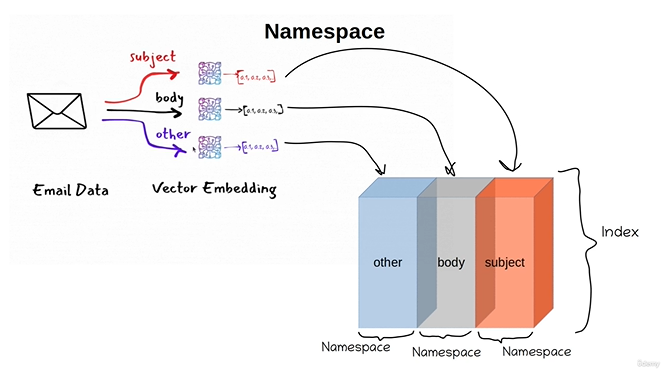

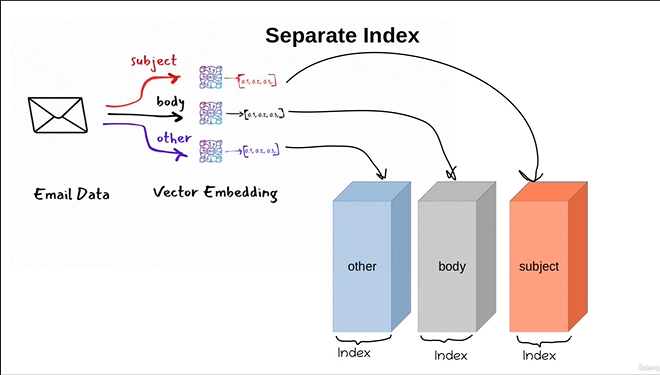


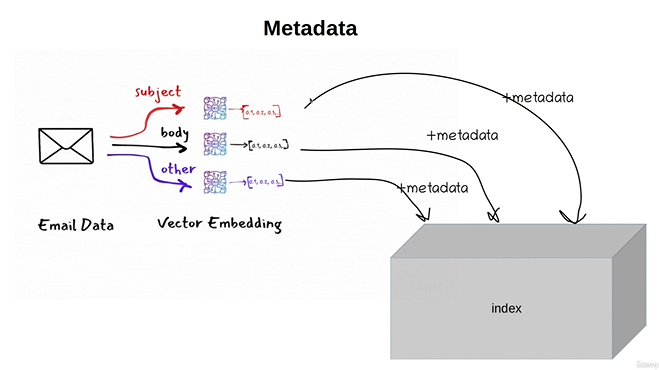

## Namespace

1) index can have one or more namespaces
2) Every vector should be only in one namespace
3) Namespace are named uniquely within a index
4) Pinecone default value for namespace is "" (empty string)

In [ ]:
import pinecone

In [ ]:
# connect the index
idx = pinecone.Index("test")

In [ ]:
dimensions = 3  # index dimension

In [ ]:
emails_with_subjects = 20
emails_with_body = 45
emails_with_other = 45

In [31]:
# create dummy vectors , assume embedding
import numpy as np

In [ ]:

vector_subject = np.random.rand(emails_with_subjects,dimensions).tolist() #(row, column)
vector_body = np.random.rand(emails_with_body,dimensions).tolist() #(row, column)
vector_other = np.random.rand(emails_with_other,dimensions).tolist() #(row, column)


In [ ]:
# create ids for these vectors
ids_subject = map(str , np.arange(emails_with_subjects).tolist()) #only strings can be upsert as ids
ids_body = map(str,np.arange(emails_with_body).tolist())
ids_other = map(str,np.arange(emails_with_other).tolist())



In [ ]:
# zip id and vectors
vectors_sub=list(zip(ids_subject , vector_subject))
vectors_body=list(zip(ids_body , vector_body))
vectors_other=list(zip(ids_other , vector_other))

In [ ]:
#upsert vectors into index with different namespace
idx.upsert(vectors_sub,namespace='subject')

In [ ]:
idx.upsert(vectors_body, namespace='body')

In [ ]:
idx.upsert(vectors_other, namespace='other')


## Meta Data

In [34]:
idx = pinecone.Index("testing")

In [35]:
#Upserting data 
idx.upsert([
    ("1",[0.1,0.1,0.1],{"topic":"subject","year":2023}),
    ("2",[0.2,0.2,0.2],{"topic":"other","year":2022}),
    ("3",[0.3,0.3,0.3],{"topic":"body","year":2023}),
    ("4",[0.4,0.4,0.4],{"topic":"body"}),
    ("5",[0.5,0.5,0.5],{"topic":"subject"})
])

ApiKeyError: "You haven't specified an Api-Key."

In [ ]:
# Query 
idx.query(vector = [0,0,0],top_k=2 ,include_metadata=True,include_values=True,
         filter={
            "topic" :{"$eq":"subject"} ,
             "year" : 2023
         })

In [ ]:
# Fetching data using id
idx.fetch(ids=['1'])

In [ ]:
# Update meta data
idx.update(id='1',
           values=[0.1,0.1,0.1],
           set_metadata = {'topic':'other','year':2020})

In [ ]:
# Delete 
idx.delete(filter = {
    "topic": {"$eq":"subject"}
})

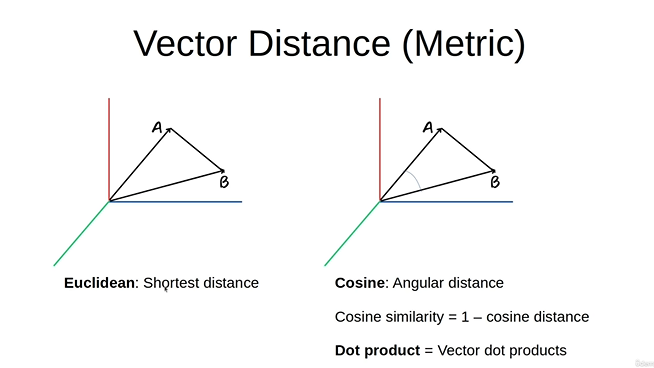


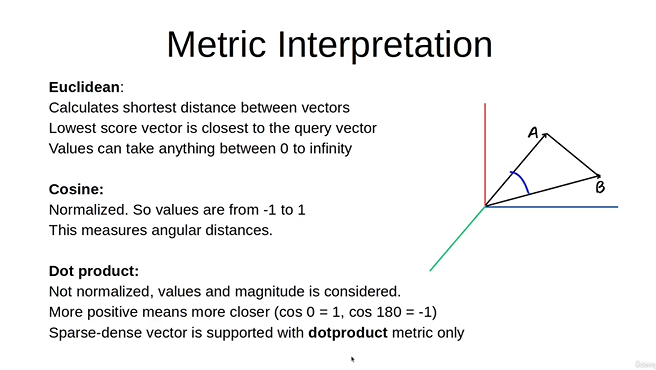


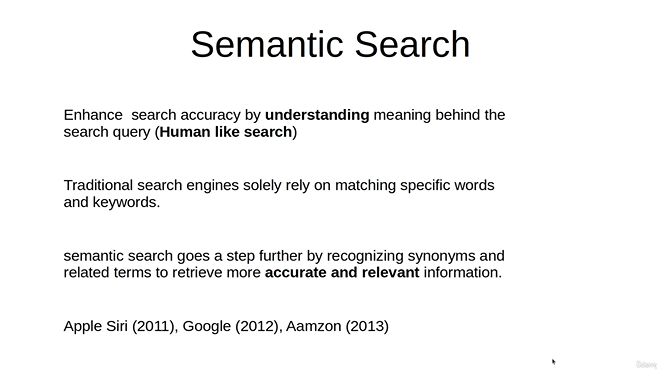


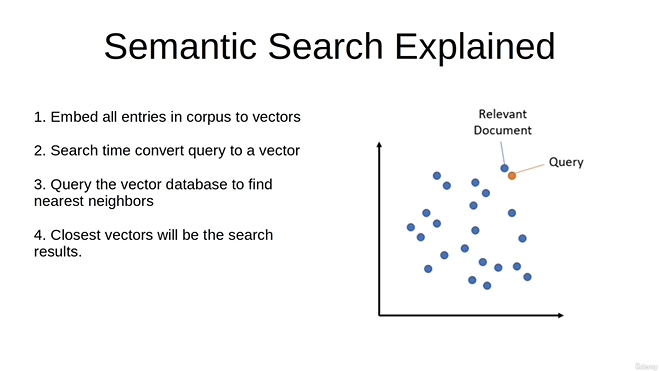

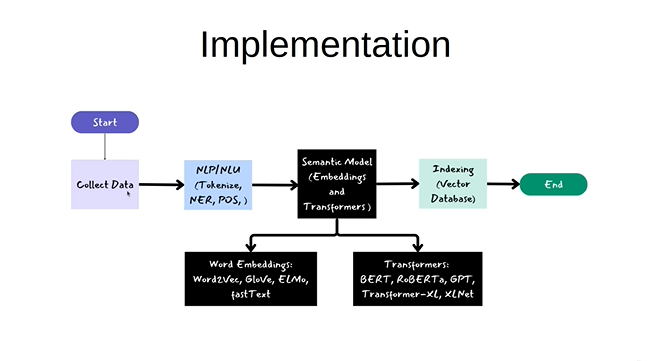

## Loding data


In [148]:
pinecone.init(
    api_key = "6855c9be-79fa-4814-938f-e24d9140c7b0",
    environment = "gcp-starter"
)

In [149]:
import pandas as pd


In [150]:
df = pd.read_csv('medium_post_titles.csv', nrows=1000)

In [151]:
df.head()

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False
3,equality,"""Call me Nat Love"" :Black Cowboys and the Fron...",NaN,False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False


## Clearning Data


In [152]:
df["subtitle_truncated_flag"].value_counts()

subtitle_truncated_flag
False    678
True     322
Name: count, dtype: int64

In [153]:
df.isna().sum()

category                    0
title                       0
subtitle                   13
subtitle_truncated_flag     0
dtype: int64

In [154]:
df  = df.dropna()

In [155]:
df.isna().sum()

category                   0
title                      0
subtitle                   0
subtitle_truncated_flag    0
dtype: int64

In [156]:
df["subtitle_truncated_flag"]

0      False
1      False
2      False
4      False
5      False
       ...  
995     True
996    False
997    False
998    False
999    False
Name: subtitle_truncated_flag, Length: 987, dtype: bool

In [157]:
df = df[~df["subtitle_truncated_flag"]]

In [158]:
df.head()

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False
5,cryptocurrency,"""Cypherpunks and Wall Street"": The Security To...",Bruce Fenton presents at the World Blockchain ...,False


stoped in 33 video and 2.58

In [159]:
df.shape

(665, 4)

In [160]:
df["title"]

0      "21 Conversations" - A fun (and easy) game for...
1                           "Biblical Porn" at Mars Hill
2                      "CISGENDER?! Is That A Disease?!"
4               "Can I Train my Model on Your Computer?"
5      "Cypherpunks and Wall Street": The Security To...
                             ...                        
994    14 UX-driven heuristics to consider when desig...
996    1408: A Horror Film’s Powerful (and Discontinu...
997        142 Resources for Mastering Coding Interviews
998               15 Awesome Marketing Tools I Use Daily
999    15 Biggest Data breaches since 2003 & how can ...
Name: title, Length: 665, dtype: object

In [161]:
df['title_extended'] = df['title']+df['subtitle']

In [162]:
# see how many unique categories that we have
df['category'].nunique()

81

## Prep for Upsert

In [163]:
pinecone.create_index(name="medium-data" , dimension=384 , pod_type='s1', metric='cosine')

ApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'X-Cloud-Trace-Context': 'b529c830d48b1ae7f51e0c1fedf05a5e', 'Date': 'Mon, 04 Mar 2024 04:59:58 GMT', 'Server': 'Google Frontend', 'Content-Length': '63', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: Capacity Reached. Projects only support a single Starter index.


In [ ]:
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2',device='cpu')

In [ ]:
model

In [ ]:
df.head(2)

In [ ]:
df['values'] = df['title_extended'].map(lambda x: (model.encode(x)).tolist())

In [ ]:
df['id']=df.reset_index(drop='index').index

In [ ]:
df['metadata'] = df.apply(lambda x: {
    'title' : x ['title'],
    'subtitle':x['subtitle'],
    'category':x['category']
},axis=1)

In [ ]:
df_upsert = df[['id','values','metadata']]

In [173]:
# converting id in to String 
df_upsert.loc[:, 'id'] = df_upsert['id'].map(lambda x: str(x))




In [174]:
df_upsert

,id,values,metadata
0,0,"[-0.031074414029717445, -0.014303464442491531,...","{'title': '""21 Conversations"" - A fun (and eas..."
1,1,"[-0.034670278429985046, -0.01816517487168312, ...","{'title': '""Biblical Porn"" at Mars Hill', 'sub..."
2,2,"[0.037407275289297104, -0.0008567898767068982,...","{'title': '""CISGENDER?! Is That A Disease?!""',..."
4,3,"[-0.013686479069292545, 0.004296062979847193, ...","{'title': '""Can I Train my Model on Your Compu..."
5,4,"[-0.031468894332647324, -0.00464660907164216, ...","{'title': '""Cypherpunks and Wall Street"": The ..."
...,...,...,...
994,660,"[-0.03809690475463867, 0.021464092656970024, 0...",{'title': '14 UX-driven heuristics to consider...
996,661,"[-0.007837142795324326, -0.013857685029506683,...",{'title': '1408: A Horror Film’s Powerful (and...
997,662,"[-0.04934856668114662, -0.022963857278227806, ...",{'title': '142 Resources for Mastering Coding ...
998,663,"[-0.09572125226259232, 0.01291677262634039, -0...",{'title': '15 Awesome Marketing Tools I Use Da...


In [175]:
pinecone.Index('meduim-data')

<class 'str'>


In [189]:
index.upsert_from_dataframe(df_upsert)

sending upsert requests:   0%|          | 0/665 [00:00<?, ?it/s]

MaxRetryError: HTTPSConnectionPool(host='meduim-data-pmqvl26.svc.gcp-starter.pinecone.io', port=443): Max retries exceeded with url: /vectors/upsert (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:2427)')))

   ---------------------------------------- 0.0/211.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/211.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/211.0 kB ? eta -:--:--
   ------- -------------------------------- 41.0/211.0 kB ? eta -:--:--
   ------- -------------------------------- 41.0/211.0 kB ? eta -:--:--
   ------------- ------------------------- 71.7/211.0 kB 653.6 kB/s eta 0:00:01
   ----------------- --------------------- 92.2/211.0 kB 871.5 kB/s eta 0:00:01
   ------------------------------------ --- 194.6/211.0 kB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 194.6/211.0 kB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 194.6/211.0 kB 1.1 MB/s eta 0:00:01
   ------------------------------------ - 204.8/211.0 kB 655.1 kB/s eta 0:00:01
   -------------------------------------- 211.0/211.0 kB 641.3 kB/s eta 0:00:00
  Attempting uninstall: pinecone-client
    Found existing installation: pinecone-c

ImportError: cannot import name 'Pinecone' from 'pinecone' (C:\Users\tperera.ext\AppData\Local\miniconda3\Lib\site-packages\pinecone\__init__.py)